### Import libraries and data
### Source: https://open.toronto.ca/dataset/non-regulated-lead-sample/ (very sparse)
### https://open.toronto.ca/dataset/toronto-s-dashboard-key-indicators/

In [84]:
pip install pmdarima

In [85]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
from matplotlib.widgets import Button, Slider

from bokeh.plotting import figure, output_file, show, curdoc
from bokeh.io import output_file
from bokeh.models import ColumnDataSource, HoverTool, Range1d, DatetimeTicker, DatetimeTickFormatter, RangeTool, CheckboxGroup
from bokeh.models import DateRangeSlider, tickers, Span
from bokeh.layouts import layout, column, row
from bokeh.models.callbacks import CustomJS
from bokeh.plotting import figure, output_file, show, save

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

In [86]:
city_dash = pd.read_csv("Toronto's Dashboard - Key metrics.csv")
city_dash = city_dash.loc[city_dash['period_number_in_year'] <= 12]
city_dash['date'] = pd.to_datetime(city_dash.year.astype(str) + '/' + city_dash.period_number_in_year.astype(str) + '/01')
city_dash.head(5)

,_id,measure_id,measure_name,interval_type,value_type,measure_value,year_to_date_variance,budget_variance,decimal_accuracy,desired_direction,category,data_source_notes,city_perspective_note,year,period_number_in_year,target,note,date
0,1,1.131,Number of Consumer Bankruptcies for the City o...,m,n,163.0,0.05,NaN,0.0,Down,Community Vulnerability,Source: Office of the Superintendent of Bankru...,NaN,2018,1,NaN,NaN,2018-01-01
1,2,1.131,Number of Consumer Bankruptcies for the City o...,m,n,197.0,0.05,NaN,0.0,Down,Community Vulnerability,Source: Office of the Superintendent of Bankru...,NaN,2018,2,NaN,NaN,2018-02-01
2,3,1.131,Number of Consumer Bankruptcies for the City o...,m,n,219.0,0.05,NaN,0.0,Down,Community Vulnerability,Source: Office of the Superintendent of Bankru...,NaN,2018,3,NaN,NaN,2018-03-01
3,4,1.131,Number of Consumer Bankruptcies for the City o...,m,n,235.0,0.05,NaN,0.0,Down,Community Vulnerability,Source: Office of the Superintendent of Bankru...,NaN,2018,4,NaN,NaN,2018-04-01
4,5,1.131,Number of Consumer Bankruptcies for the City o...,m,n,253.0,0.05,NaN,0.0,Down,Community Vulnerability,Source: Office of the Superintendent of Bankru...,NaN,2018,5,NaN,NaN,2018-05-01


In [87]:
measure_to_plot = 'Average Home Price (City of Toronto)'

dates = np.array(city_dash[city_dash['measure_name'] == measure_to_plot]['date'], dtype=np.datetime64)
measure = city_dash[city_dash['measure_name'] == measure_to_plot]
source = ColumnDataSource(data=dict(date=dates, measure=measure['measure_value']))

p = figure(height=600, width=1500, tools="xpan, box_zoom, save, reset", toolbar_location='right',
           x_axis_type="datetime", x_axis_location="below",
           background_fill_color="#efefef", x_range=(dates[0], dates[-1]))

hover = HoverTool(tooltips = [("Date", '@date{%F}'),
                              (measure_to_plot, "@measure{0,0.0}")],
                  formatters={'@date': 'datetime',
                              measure_to_plot : 'printf',}#, mode='vline'
)
p.add_tools(hover)

p.line('date', 'measure', source=source, line_color = '#1f77b4', legend_label=measure_to_plot)
p.yaxis.axis_label = measure_to_plot
p.xaxis.axis_label = 'Date'
p.xaxis.ticker.desired_num_ticks = 15

select = figure(title="Drag the middle and edges of the selection box to change the date range",
                height=100, width=1500, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool_x = RangeTool(x_range=p.x_range)
range_tool_x.overlay.fill_color = "navy"
range_tool_x.overlay.fill_alpha = 0.2

select.line('date', 'measure', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool_x)

p.legend.location = "top_left"
p.legend.click_policy="hide"

# Horizontal line
hline = Span(location=0, dimension='width', line_color='black', line_width=1)
p.renderers.extend([hline])

output_file('Average_Home_Price.html')
show(column(p, select))

In [88]:
measure_to_plot = 'TTC Average Weekday Ridership'

dates = np.array(city_dash[city_dash['measure_name'] == measure_to_plot]['date'], dtype=np.datetime64)
measure = city_dash[city_dash['measure_name'] == measure_to_plot]
source = ColumnDataSource(data=dict(date=dates, measure=measure['measure_value']))

p = figure(height=600, width=1500, tools="xpan, box_zoom, save, reset", toolbar_location='right',
           x_axis_type="datetime", x_axis_location="below",
           background_fill_color="#efefef", x_range=(dates[0], dates[-1]))

hover = HoverTool(tooltips = [("Date", '@date{%F}'),
                              (measure_to_plot, "@measure{0,0.0}")],
                  formatters={'@date': 'datetime',
                              measure_to_plot : 'printf',}#, mode='vline'
)
p.add_tools(hover)

p.line('date', 'measure', source=source, line_color = '#1f77b4', legend_label=measure_to_plot)
p.yaxis.axis_label = measure_to_plot
p.xaxis.axis_label = 'Date'
p.xaxis.ticker.desired_num_ticks = 15

select = figure(title="Drag the middle and edges of the selection box to change the date range",
                height=100, width=1500, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool_x = RangeTool(x_range=p.x_range)
range_tool_x.overlay.fill_color = "navy"
range_tool_x.overlay.fill_alpha = 0.2

select.line('date', 'measure', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool_x)

p.legend.location = "top_left"
p.legend.click_policy="hide"

# Horizontal line
hline = Span(location=0, dimension='width', line_color='black', line_width=1)
p.renderers.extend([hline])

output_file('TTC_Average_Weekday_Ridership.html')
show(column(p, select))

In [89]:
measure_to_plot = 'Number of Home Sales (City of Toronto)'

dates = np.array(city_dash[city_dash['measure_name'] == measure_to_plot]['date'], dtype=np.datetime64)
measure = city_dash[city_dash['measure_name'] == measure_to_plot]
source = ColumnDataSource(data=dict(date=dates, measure=measure['measure_value']))

p = figure(height=600, width=1500, tools="xpan, box_zoom, save, reset", toolbar_location='right',
           x_axis_type="datetime", x_axis_location="below",
           background_fill_color="#efefef", x_range=(dates[0], dates[-1]))

hover = HoverTool(tooltips = [("Date", '@date{%F}'),
                              (measure_to_plot, "@measure{0,0.0}")],
                  formatters={'@date': 'datetime',
                              measure_to_plot : 'printf',}#, mode='vline'
)
p.add_tools(hover)

p.line('date', 'measure', source=source, line_color = '#1f77b4', legend_label=measure_to_plot)
p.yaxis.axis_label = measure_to_plot
p.xaxis.axis_label = 'Date'
p.xaxis.ticker.desired_num_ticks = 15

select = figure(title="Drag the middle and edges of the selection box to change the date range",
                height=100, width=1500, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool_x = RangeTool(x_range=p.x_range)
range_tool_x.overlay.fill_color = "navy"
range_tool_x.overlay.fill_alpha = 0.2

select.line('date', 'measure', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool_x)

p.legend.location = "top_left"
p.legend.click_policy="hide"

# Horizontal line
hline = Span(location=0, dimension='width', line_color='black', line_width=1)
p.renderers.extend([hline])

output_file('Number_of_Home_Sales.html')
show(column(p, select))

### 1.1 Exploring the Data:

In [90]:
# Extracting data for 'Average Home Price (City of Toronto)'.
average_home_price_data = city_dash[city_dash['measure_name'] == 'Average Home Price (City of Toronto)'].copy()
average_home_price_data.dropna(subset=['measure_value'], inplace=True)
average_home_price_data = average_home_price_data[['date', 'measure_value']].rename(columns={'measure_value': 'Home Price'})
average_home_price_data = average_home_price_data.set_index('date', drop=True)
average_home_price_data.head()

,Home Price
date,
2009-01-01,364416.0
2009-02-01,392919.0
2009-03-01,387793.0
2009-04-01,421470.0
2009-05-01,432478.0


In [91]:
# Extracting data for 'Number of Home Sales (City of Toronto)'.
home_sales_data = city_dash[city_dash['measure_name'] == 'Number of Home Sales (City of Toronto)'].copy()
home_sales_data.dropna(subset=['measure_value'], inplace=True)
home_sales_data = home_sales_data[['date', 'measure_value']].rename(columns={'measure_value': 'Home Sales'})
home_sales_data = home_sales_data.set_index('date', drop=True)
home_sales_data.head()

,Home Sales
date,
2009-01-01,1106.0
2009-02-01,1653.0
2009-03-01,2398.0
2009-04-01,3222.0
2009-05-01,3777.0


In [92]:
# Saving locally the real-estate data of interest.
average_home_price_data.to_csv('average_home_price_data.csv')
home_sales_data.to_csv('home_sales_data.csv')

In [93]:
# Splitting 'Average Home Price (City of Toronto)'
price_train = average_home_price_data.loc[average_home_price_data.index < '2020-01-01']
price_test = average_home_price_data.loc[average_home_price_data.index >= '2020-01-01']
# Splitting 'Number of Home Sales (City of Toronto)'
sales_train = home_sales_data.loc[home_sales_data.index < '2020-01-01']
sales_test = home_sales_data.loc[home_sales_data.index >= '2020-01-01']
# Confirming the split for the different datsets.
print("Training set size (Home Price):", price_train.shape)
print("Test set size (Home Price):", price_test.shape)
print("Training set size (Home Sales):", sales_train.shape)
print("Test set size (Home Sales):", sales_test.shape)

Training set size (Home Price): (132, 1)
Test set size (Home Price): (60, 1)
Training set size (Home Sales): (132, 1)
Test set size (Home Sales): (60, 1)


In [94]:
# Creating lists to easily access the data and names for loops.
measure_data = [price_train['Home Price'], sales_train['Home Sales']]
measure_name = ['Home Price', 'Home Sales']

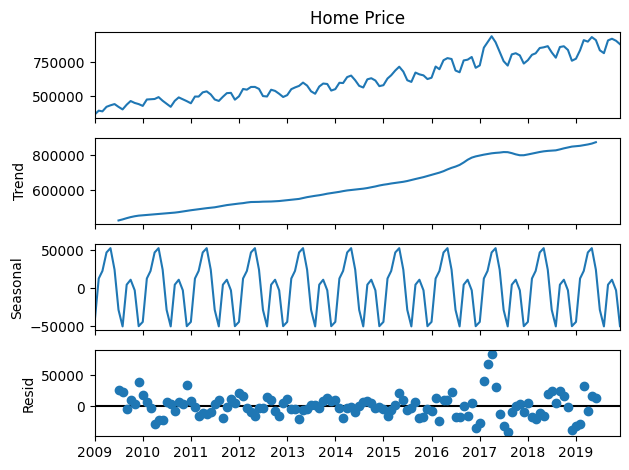

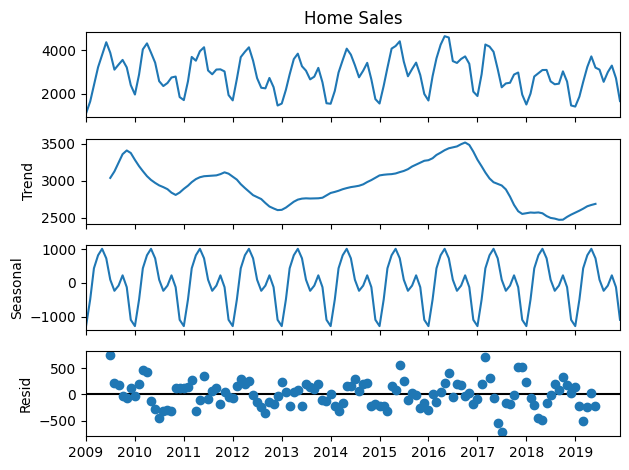

In [95]:
# Defining a function for seasonal decomposition.
def seasonal_decomposition(measure):
  result = seasonal_decompose(measure, model='additive')
  result.plot()

# Running the function for both datasets.
for measure in measure_data:
  seasonal_decomposition(measure)

#### Analysis (Trends, Seasonality and Residuals):
Regarding Historical Data on Home Prices: The original data plot displays a consistent increasing trend with discernible oscillations in prices over time.
 -  Prices have been rising gradually over time, as evidenced by the trend plot's steady upward trend, particularly after 2015.
 -   The highly cyclical pattern displayed by the seasonal plot indicates that housing prices fluctuate predictably throughout the year, peaking in the spring and falling in the winter.
 -  Random noise is indicated by the residual plot points around zero, with a few strong spikes that hint to unforeseen circumstances or market disruptions like policy changes at particular times.

Regarding Historical Data on Home Sales: The original data plot displays a very variable pattern with distinct peaks and troughs.
 -  After 2016, there is a discernible drop in the trend plot, which could be the result of shifting policies or economic factors that impact consumer demand.
 -  Home sales appear to follow a predictable annual cycle, as seen by the seasonal plot's pattern of regular peaks and valleys. This cycle is probably impacted by things like winter slowdowns and spring/summer sales spikes.
 -  There are several significant deviations in the residual plot, which point to unforeseen circumstances or outside shocks.

### 1.2 Developing a Forcasting Model:

In [96]:
# Definingn a function that checks for stationarity.
def check_stationarity(measure, name):
    adf_value = adfuller(measure)  # Apply ADF test to the series
    print(f"Results for {name}:")
    print(f"ADF Statistic: {adf_value[0]:.2f}")
    print(f"p-value: {adf_value[1]:.3f}")
    print("Critical Values:", adf_value[4])

    if adf_value[1] < 0.05:
        print(f"The {name} time series is stationary (reject H0).\n")
    else:
        print(f"The {name} time series is non-stationary (fail to reject H0).\n")

for measure, name in zip(measure_data, measure_name):
    check_stationarity(measure, name)

Results for Home Price:
ADF Statistic: 0.62
p-value: 0.988
Critical Values: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
The Home Price time series is non-stationary (fail to reject H0).

Results for Home Sales:
ADF Statistic: -2.39
p-value: 0.143
Critical Values: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
The Home Sales time series is non-stationary (fail to reject H0).



#### Comment on Stationarity:
- The p-values for both Home Price and Home Sales are above 5% indicating that both are non-stationary data. Differencing would be used to make the data stationary for forcasting techniques.

In [97]:
# First-Order Differencing for Home Price
price_train['d1_Home Price'] = price_train['Home Price'].diff()
price_train.head()

,Home Price,d1_Home Price
date,,
2009-01-01,364416.0,NaN
2009-02-01,392919.0,28503.0
2009-03-01,387793.0,-5126.0
2009-04-01,421470.0,33677.0
2009-05-01,432478.0,11008.0


In [98]:
# First-Order Differencing for Home Sales
sales_train['d1_Home Sales'] = sales_train['Home Sales'].diff()
sales_train.head()

,Home Sales,d1_Home Sales
date,,
2009-01-01,1106.0,NaN
2009-02-01,1653.0,547.0
2009-03-01,2398.0,745.0
2009-04-01,3222.0,824.0
2009-05-01,3777.0,555.0


In [99]:
# Removing the one missing value from the datasets.
price_train = price_train.dropna(subset=['d1_Home Price'])
sales_train = sales_train.dropna(subset=['d1_Home Sales'])

# Creating lists to easily access the data and names for loops.
d1_measure_data = [price_train['d1_Home Price'], sales_train['d1_Home Sales']]
d1_measure_name = ['d1_Home Price', 'd1_Home Sales']

# Checking for stationarity on first-order differenced data.
for measure, name in zip(d1_measure_data, d1_measure_name):
    check_stationarity(measure, name)

Results for d1_Home Price:
ADF Statistic: -3.45
p-value: 0.009
Critical Values: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
The d1_Home Price time series is stationary (reject H0).

Results for d1_Home Sales:
ADF Statistic: -3.86
p-value: 0.002
Critical Values: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
The d1_Home Sales time series is stationary (reject H0).



#### Comment on Stationarity:
The p-value of the first-order differences for both datasets is less than 5% and very close to zero which means that the first-order differences are stationary.

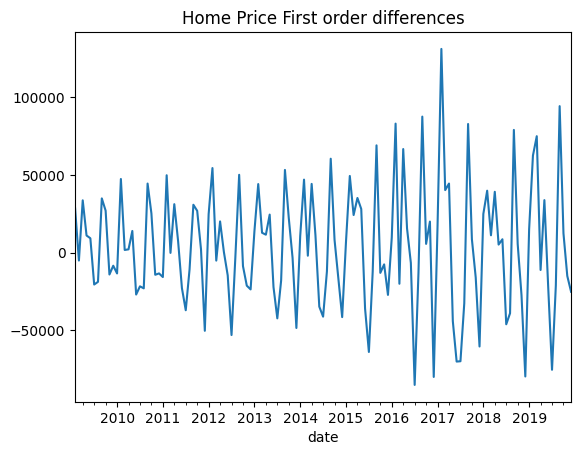

In [100]:
# Visualizing the first-order differences for Home Price.
price_train['d1_Home Price'].plot(title="Home Price First order differences").autoscale(axis='x',tight=True);

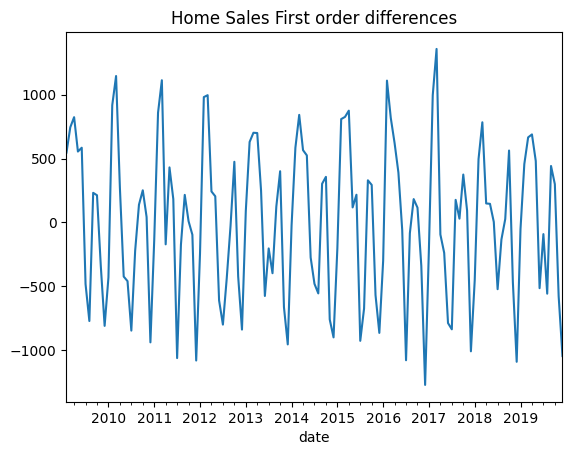

In [101]:
# Visualizing the first-order differences for Home Sales.
sales_train['d1_Home Sales'].plot(title="Home Sales First order differences").autoscale(axis='x',tight=True);

In [102]:
# Using 2017-01-01 and beyond as the validation set for model selection.
split_date = '2017-01-01'
# Splitting 'Average Home Price (City of Toronto)'
price_train_split = price_train.loc[price_train.index < split_date]  # Training set
price_val = price_train.loc[price_train.index >= split_date]  # Validation set
# Splitting 'Number of Home Sales (City of Toronto)'
sales_train_split = sales_train.loc[sales_train.index < split_date]  # Training set
sales_val = sales_train.loc[sales_train.index >= split_date]  # Validation set

# Confirming the split for the different datasets
print("Training set size (Home Price):", price_train_split.shape)
print("Validation set size (Home Price):", price_val.shape)
print("Training set size (Home Sales):", sales_train_split.shape)
print("Validation set size (Home Sales):", sales_val.shape)

Training set size (Home Price): (95, 2)
Validation set size (Home Price): (36, 2)
Training set size (Home Sales): (95, 2)
Validation set size (Home Sales): (36, 2)


In [103]:
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

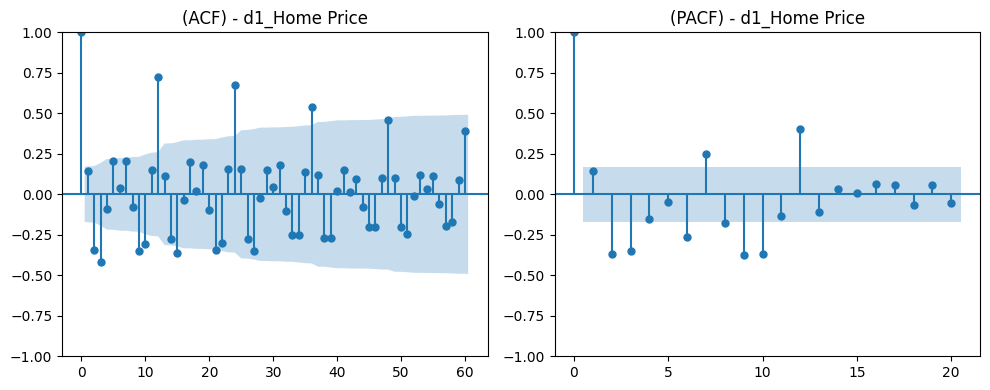

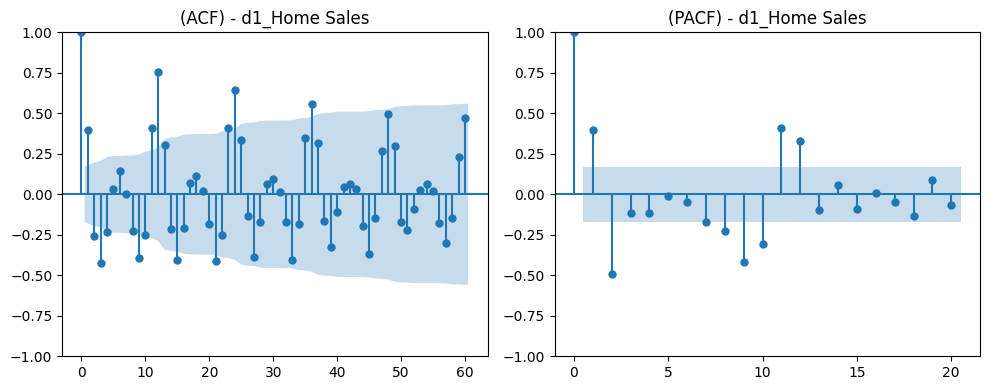

In [104]:
# Looping through datasets and generating ACF and PACF plots.
for i, data in enumerate(d1_measure_data):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    plot_acf(data, lags=60, ax=axes[0])  # ACF Plot
    axes[0].set_title(f"(ACF) - {d1_measure_name[i]}")

    plot_pacf(data, lags=20, ax=axes[1], method="ywm")  # PACF Plot
    axes[1].set_title(f"(PACF) - {d1_measure_name[i]}")

    plt.tight_layout()
    plt.show()

#### Observations for differenced data (ACF and PACF plots):
d1_Price of Home:
 - ACF Plot: Possible MA terms are suggested by the correlation's slow decay. Significant spikes at particular lags indicate possible AR terms in the PACF plot.

d1_Home Sales:
 - ACF Plot: The steady drop points to possible MA terms, much like the home price data. Significant spikes at particular lags indicate possible AR terms in the PACF plot.

#### A. Exponential Smoothing (ETS) Model.

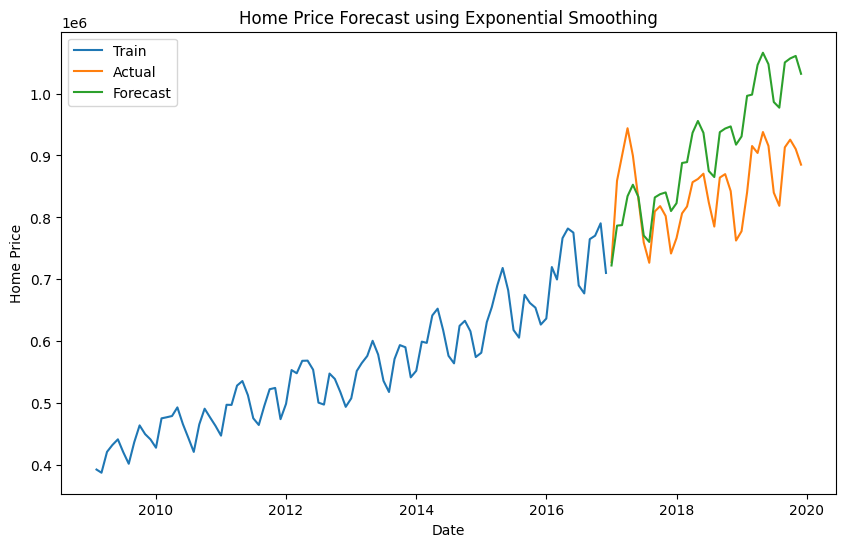

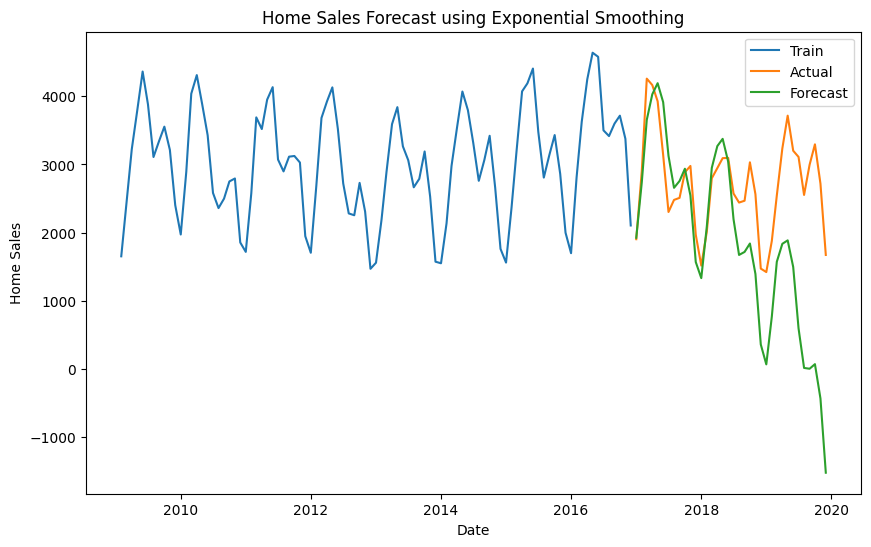

In [105]:
# Exponential Smoothing Model.
def exponential_smoothing_forecast(train_data, val_data, column_name):
    # Fitting Exponential Smoothing model on the differenced data.
    model = ExponentialSmoothing(train_data[f'd1_{column_name}'], trend='add', seasonal='add', seasonal_periods=12)
    model_fit = model.fit()
    # Forecasting the next N data points (size of validation set).
    forecast_diff = model_fit.forecast(len(val_data))
    # Reversing differencing to get actual values.
    last_value = train_data[column_name].iloc[-1]  # Last actual value before differencing.
    forecast_actual = last_value + forecast_diff.cumsum()  # Cumulative sum to get actual values.
    # Plotting the actual and forecasted values.
    plt.figure(figsize=(10, 6))
    plt.plot(train_data[column_name], label='Train')
    plt.plot(val_data[column_name], label='Actual')
    plt.plot(forecast_actual, label='Forecast')
    plt.legend(loc='best')
    plt.title(f'{column_name} Forecast using Exponential Smoothing')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.show()
    return forecast_actual

# Saving ES Forcast data for Home Price and Home Sales:
es_forecast_hp = exponential_smoothing_forecast(price_train_split, price_val, 'Home Price')
es_forecast_hs = exponential_smoothing_forecast(sales_train_split, sales_val, 'Home Sales')

#### B. Autoregression(AR) Model.

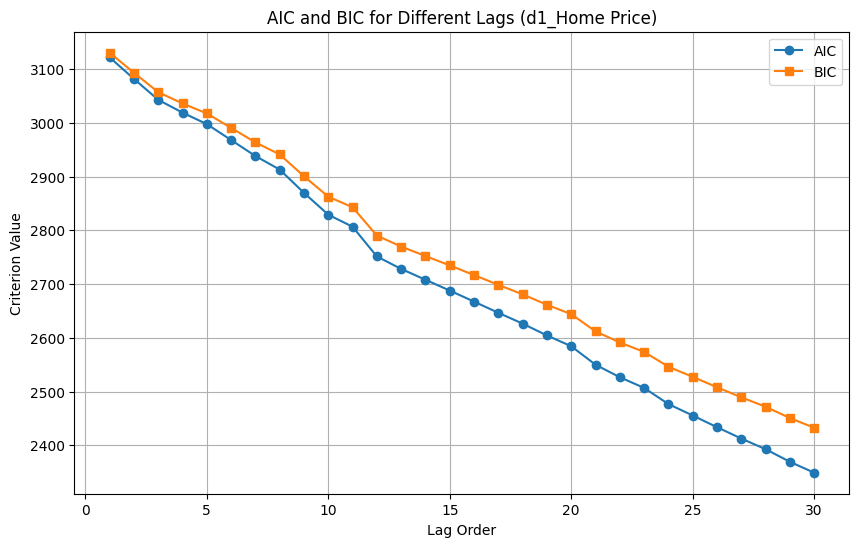

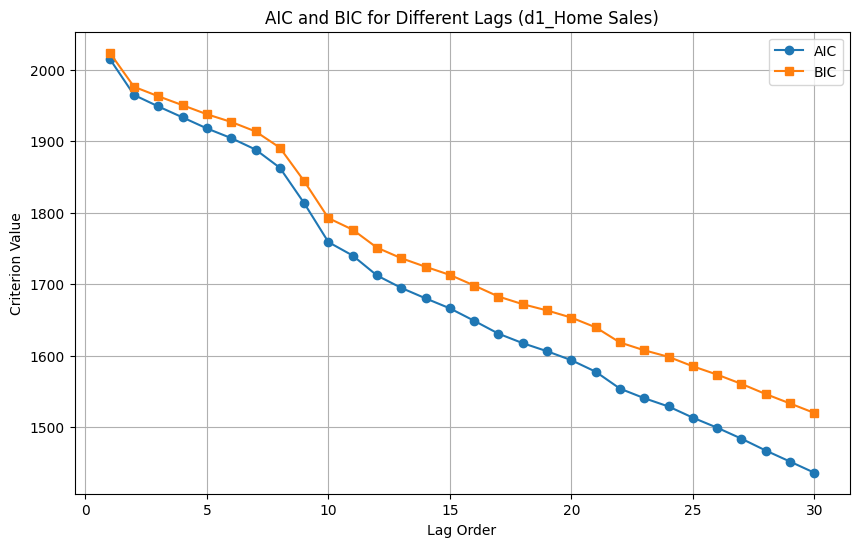

In [106]:
# Defining function to obtain optimal lag for Autoregression.
def plot_aic_bic(train_data, column_name, max_lag=30):
    aic_scores = []
    bic_scores = []
    lags_list = range(1, max_lag + 1)
    # Fitting AR models and store AIC and BIC scores.
    for lag in lags_list:
        model = AutoReg(train_data[column_name], lags=lag, trend='t')
        model_fit = model.fit()
        aic_scores.append(model_fit.aic)
        bic_scores.append(model_fit.bic)
    # Plotting AIC and BIC scores for visual comparison.
    plt.figure(figsize=(10, 6))
    plt.plot(lags_list, aic_scores, label='AIC', marker='o')
    plt.plot(lags_list, bic_scores, label='BIC', marker='s')
    plt.xlabel('Lag Order')
    plt.ylabel('Criterion Value')
    plt.title(f'AIC and BIC for Different Lags ({column_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting for both datasets.
plot_aic_bic(price_train, 'd1_Home Price')
plot_aic_bic(sales_train, 'd1_Home Sales')

#### Analysis of AiC BiC plots:
From observation, the optimal lag order is 12 for both Home Price data and Home Sales data.

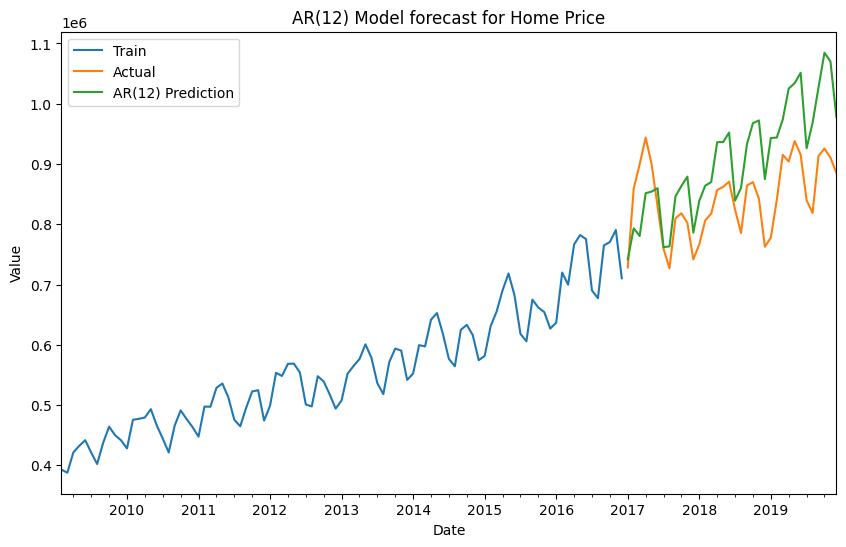

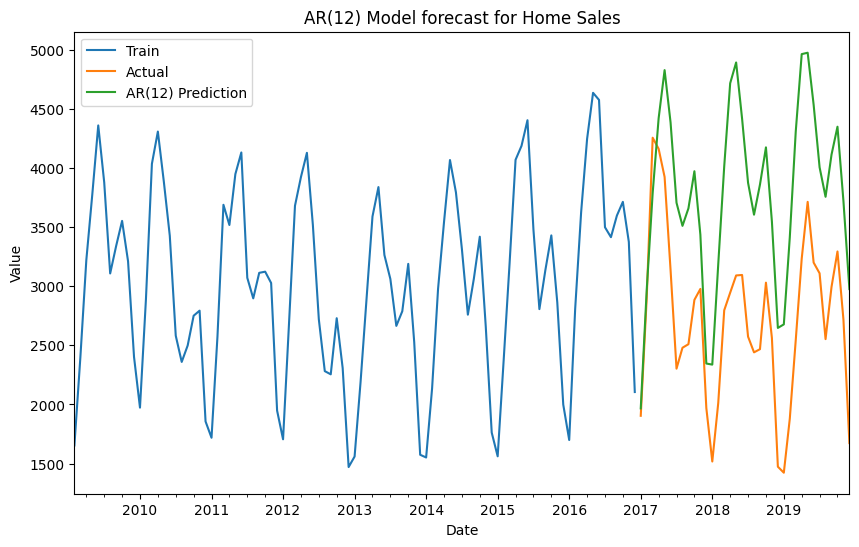

In [107]:
# Autoregression(AR) Model.
def Autoregression_forcast(train_data, val_data, column_name, optimal_lag):
    # Fitting the AR model.
    model = AutoReg(train_data[f'd1_{column_name}'], lags=optimal_lag, trend='t')
    model_fit = model.fit()
    # Defining the start and end indices for predictions.
    start = len(train_data)  # Start at the length of the training set.
    end = len(train_data) + len(val_data) - 1  # End at the length of the train set + validation set length - 1
    # Making predictions on the validation set.
    forecast_diff = model_fit.predict(start=start, end=end, dynamic=False).rename(f'AR({optimal_lag}) predictions')
    # Convert back to actual values by reversing differencing
    last_value = train_data[column_name].iloc[-1]  # Last actual value before validation starts
    forecast_actual = last_value + forecast_diff.cumsum()
    # Plotting the results.
    plt.figure(figsize=(10, 6))
    train_data[column_name].plot(legend=True, label='Train')
    val_data[column_name].plot(legend=True, label='Actual')
    forecast_actual.plot(legend=True, label=f'AR({optimal_lag}) Prediction')
    # Setting the plot labels and title.
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'AR({optimal_lag}) Model forecast for {column_name}')
    plt.legend()
    plt.show()
    return forecast_actual

# Saving AR Forcast data for Home Price and Home Sales.
ar_forcast_hp = Autoregression_forcast(price_train_split, price_val, 'Home Price', optimal_lag=12)
ar_forcast_hs = Autoregression_forcast(sales_train_split, sales_val, 'Home Sales', optimal_lag=12)

#### C. ARIMA Model.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2230.442, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2232.366, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2232.398, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2229.389, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2234.688, Time=1.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.703 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   95
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1113.695
Date:                Sun, 09 Mar 2025   AIC                           2229.389
Time:                        05:42:10   BIC                           2231.932
Sample:                    02-01-2009   HQIC                          2230.416
               

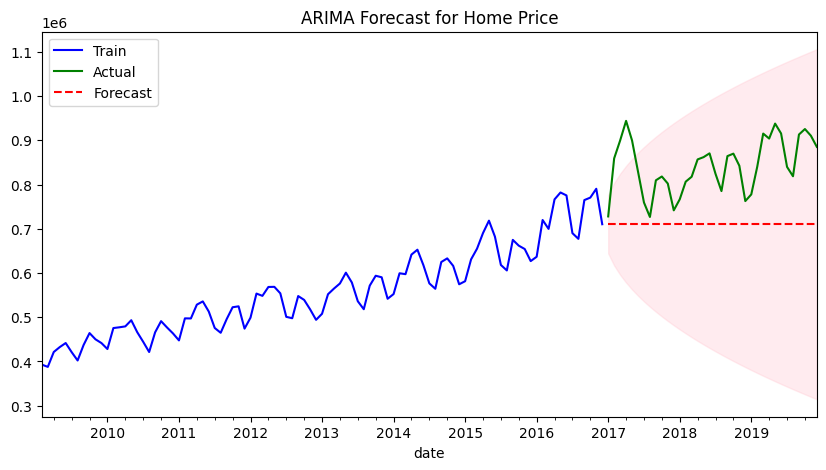

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1431.273, Time=2.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1543.595, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1480.467, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1464.554, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1800.867, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1435.370, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1432.648, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1433.050, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1434.189, Time=1.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1440.257, Time=1.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1435.895, Time=0.75 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1432.742, Time=0.85 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.80 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] interc

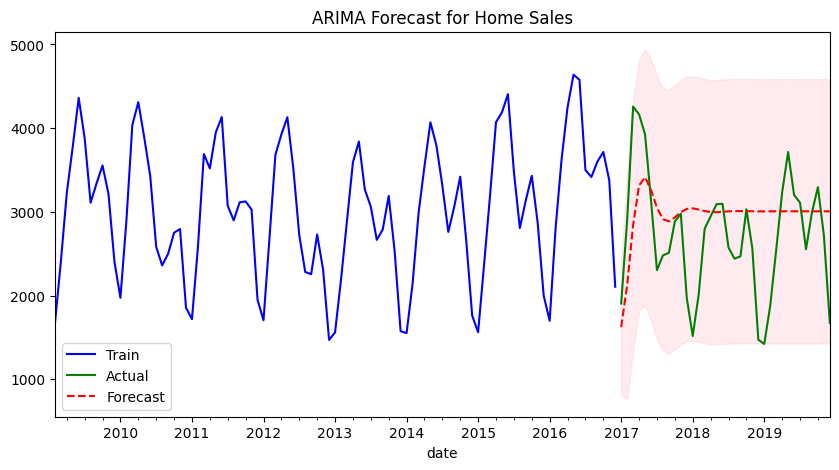

In [108]:
# ARIMA Model.
def arima_forcast(train_data, val_data, column_name):
    # Fitting the ARIMA model using auto_arima.
    model = pm.auto_arima(train_data[column_name],
                          seasonal=True,  # Set to True as seasonality is suspected.
                          stepwise=True,  # Tries different (p,d,q) combinations.
                          suppress_warnings=True,
                          trace=True)  # Show search process.
    # Printing the selected ARIMA model.
    print(model.summary())
    # Forecasting the validation set.
    n_periods = len(val_data)  # Number of periods to forecast.
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    # Creating index for forecasts.
    forecast_index = val_data.index  # Aligning forecast with validation set index.
    forecast_series = pd.Series(forecast, index=forecast_index, name=f'Auto ARIMA Prediction')
    # Plotting the results.
    plt.figure(figsize=(10, 5))
    train_data[column_name].plot(label="Train", color="blue")
    val_data[column_name].plot(label="Actual", color="green")
    forecast_series.plot(label="Forecast", color="red", linestyle="dashed")
    # Plotting the confidence intervals.
    plt.fill_between(forecast_index,
                     conf_int[:, 0], conf_int[:, 1],
                     color="pink", alpha=0.3)
    plt.legend()
    plt.title(f"ARIMA Forecast for {column_name}")
    plt.show()
    return forecast_series

# Saving ARIMA Forcast data for Home Price and Home Sales.
arima_forecast_hp = arima_forcast(price_train_split, price_val, 'Home Price')
arima_forecast_hs = arima_forcast(sales_train_split, sales_val, 'Home Sales')

#### D. SARIMA Model.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1847.382, Time=2.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1848.920, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1845.959, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1846.784, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1847.127, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1844.871, Time=1.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1844.338, Time=2.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1845.272, Time=0.48 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=9.14 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1844.238, Time=1.34 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1857.397, Time=1.22 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=1843.905, Time=1.25 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1845.460, Time=0.52 sec
 ARIMA(2,1,0)(1,1,2)[12]     

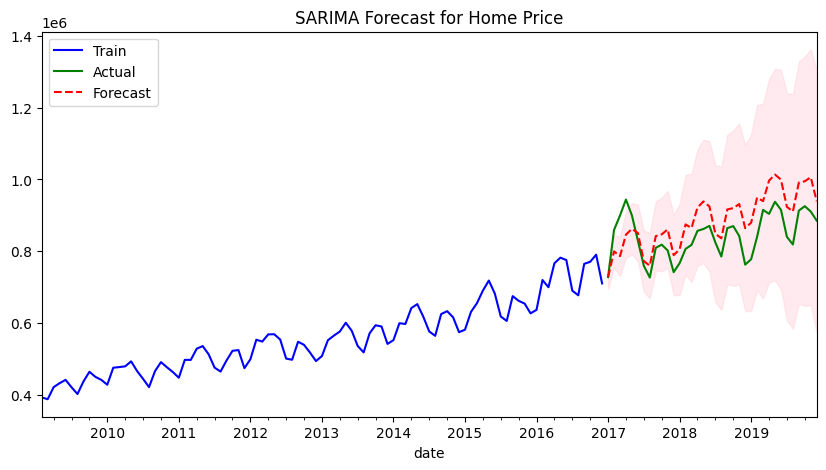

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1543.595, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1383.885, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1428.634, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1800.867, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1480.467, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1405.268, Time=1.28 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1399.269, Time=0.61 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1434.738, Time=0.32 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1542.615, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1380.093, Time=0.79 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1432.610, Time=0.05 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1401.354, Time=1.58 sec
 ARIMA(2,0,0)(1,0,1)[12] inte

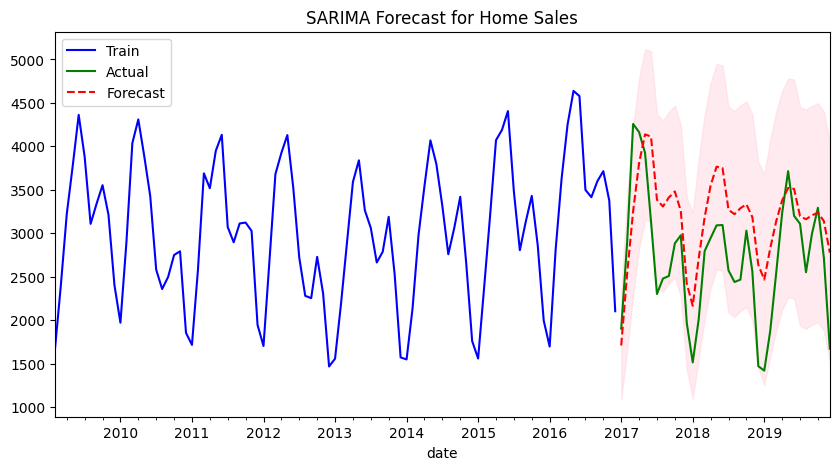

In [76]:
# SARIMA Model.
def sarima_forcast(train_data, val_data, column_name, seasonal_period=12):
    # Fitting the SARIMA model using auto_arima with seasonal_period=12.
    model = pm.auto_arima(train_data[column_name],
                          seasonal=True,      # Enables seasonal ARIMA (SARIMA).
                          m=seasonal_period,  # Defines the seasonal period (12 for yearly).
                          stepwise=True,      # Tries different (p,d,q) and (P,D,Q,m) combinations.
                          suppress_warnings=True,
                          trace=True)         # Show search process.
    # Printing the selected SARIMA model.
    print(model.summary())
    # Forecasting the validation set.
    n_periods = len(val_data)  # Number of periods to forecast.
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    # Creating the index for forecasts.
    forecast_index = val_data.index  # Align forecast with validation set index.
    forecast_series = pd.Series(forecast, index=forecast_index, name=f'SARIMA Prediction')
    # Plotting the results.
    plt.figure(figsize=(10, 5))
    train_data[column_name].plot(label="Train", color="blue")
    val_data[column_name].plot(label="Actual", color="green")
    forecast_series.plot(label="Forecast", color="red", linestyle="dashed")
    # Plotting the confidence intervals.
    plt.fill_between(forecast_index,
                     conf_int[:, 0], conf_int[:, 1],
                     color="pink", alpha=0.3)
    plt.legend()
    plt.title(f"SARIMA Forecast for {column_name}")
    plt.show()
    return forecast_series

# Saving SARIMA Forcast data for Home Price and Home Sales.
sarima_forecast_hp = sarima_forcast(price_train_split, price_val, 'Home Price')
sarima_forecast_hs = sarima_forcast(sales_train_split, sales_val, 'Home Sales')

#### Model Evaluation and Selection:

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [78]:
# Defining a function to compute error metrics.
def evaluate_model(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, rmse, mape

In [79]:
# Defining forcasts for both Home Price and Home Sales separately.
models_forcast_hp = {"ETS": es_forecast_hp,
                     "AR": ar_forcast_hp,
                     "ARIMA": arima_forecast_hp,
                     "SARIMA": sarima_forecast_hp}
models_forcast_hs = {"ETS": es_forecast_hs,
                     "AR": ar_forcast_hs,
                     "ARIMA": arima_forecast_hs,
                     "SARIMA": sarima_forecast_hs}

In [80]:
# Initializing lists to store the results
error_metrics_hp = []
error_metrics_hs = []
# Evaluating models for Home Price.
for model_name, predictions in models_forcast_hp.items():
    mae_hp, rmse_hp, mape_hp = evaluate_model(predictions, price_val['Home Price'])
    error_metrics_hp.append([model_name, mae_hp, rmse_hp, mape_hp])
# Evaluating models for Home Sales.
for model_name, predictions in models_forcast_hs.items():
    mae_hs, rmse_hs, mape_hs = evaluate_model(predictions, sales_val['Home Sales'])
    error_metrics_hs.append([model_name, mae_hs, rmse_hs, mape_hs])
# Creating DataFrames for Home Price and Home Sales results.
columns = ['Model', 'MAE', 'RMSE', 'MAPE (%)']
hp_results_df = pd.DataFrame(error_metrics_hp, columns=columns)
hs_results_df = pd.DataFrame(error_metrics_hs, columns=columns)
# Displaying results.
print("Home Price Model Evaluation:")
hp_results_df

Home Price Model Evaluation:


,Model,MAE,RMSE,MAPE (%)
0,ETS,88692.120544,100632.130352,9.406854
1,AR,82374.594178,92495.614913,8.832449
2,ARIMA,132183.527778,145294.501005,18.609352
3,SARIMA,61683.511076,68177.125865,6.859688


In [81]:
print("\nHome Sales Model Evaluation:")
hs_results_df


Home Sales Model Evaluation:


,Model,MAE,RMSE,MAPE (%)
0,ETS,1014.038203,1415.813500,2493.695395
1,AR,1090.932996,1174.633289,28.716447
2,ARIMA,554.405202,730.654601,18.885954
3,SARIMA,584.442474,663.771920,18.981210


#### Justification for Model choice.
The chosen Model is SARIMA.
- For home price, SARIMA performs better than the other models (Exponential Smoothing, AR, and ARIMA) in terms of MAE, RMSE, and MAPE.  It is the most accurate model for predicting home prices since it offers the lowest error metrics for home price.
- While ARIMA performs better than SARIMA in home sales, SARIMA still has the lowest RMSE and produces good outcomes with competitive MAE and MAPE values.  The performance difference isn't that great, and SARIMA offers a reasonable balance between the two datasets (i.e., it's a decent all-around model for both Home Price and Home Sales), even if ARIMA performs better for Home Sales.
-  SARIMA performs exceptionally well with managing trend and seasonality.  Trends and seasonality are prevalent in the context of property markets, and SARIMA takes both into consideration, making it the ideal option for home price.  Even while SARIMA is not as effective as ARIMA for home sales, it nevertheless effectively reflects the underlying patterns.

### 1.3 Making Predictions:

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3122.424, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3076.234, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3093.162, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3121.638, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3123.195, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3067.513, Time=0.54 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3067.981, Time=0.72 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3068.494, Time=0.19 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3066.801, Time=0.37 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3075.286, Time=0.08 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3067.792, Time=0.65 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3068.797, Time=0.14 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=3069.706, Time=0.63 sec
 ARIMA(1,1,1)(2,0,0)[12]

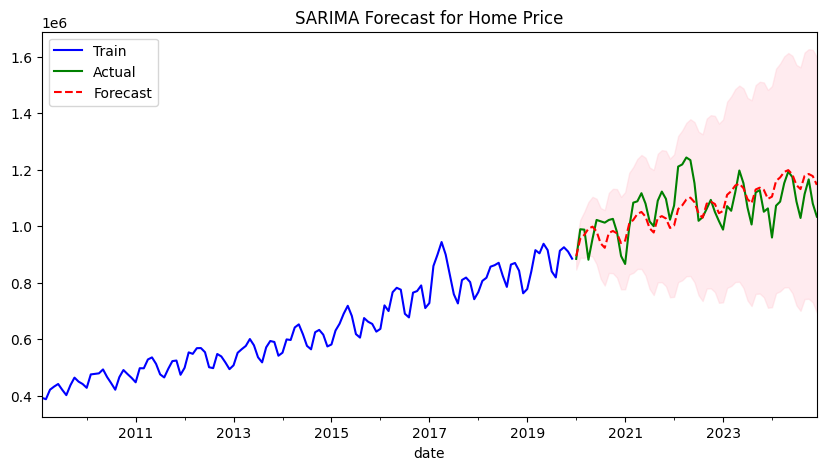

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1917.930, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2122.108, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1907.651, Time=0.83 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1964.689, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2475.224, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2035.618, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1965.580, Time=2.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1953.471, Time=0.86 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1962.707, Time=0.84 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2020.691, Time=0.51 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1947.948, Time=0.96 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1922.336, Time=0.44 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1948.313, Time=0.50 sec
 ARIMA(2,0,1)(1,0,0)[12]

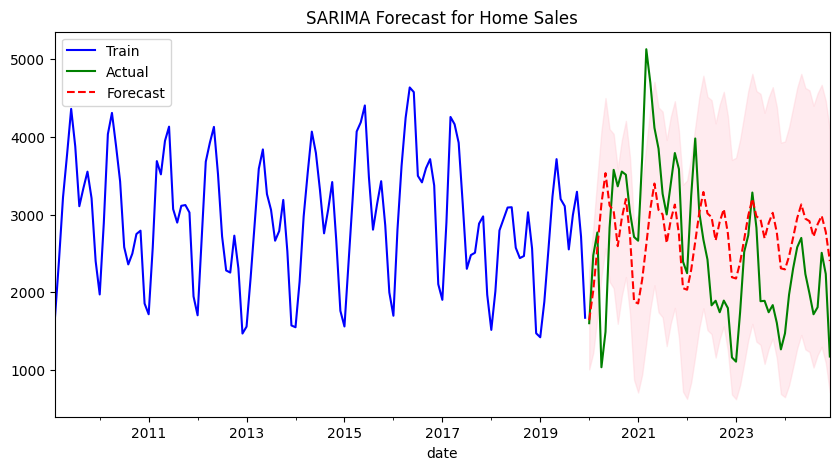

In [82]:
# Training the model using data up to December 31, 2019 (price_train and sales_train).
# Forecasting housing prices and sales from January 1, 2020, to December 31, 2024 (price_test and sales_test).
sarima_prediction_hp = sarima_forcast(price_train, price_test, 'Home Price')
sarima_prediction_hs = sarima_forcast(sales_train, sales_test, 'Home Sales')

### 1.4 Comparing with Actual Data:

In [83]:
# Computing error metrics (e.g., MAE, RMSE, MAPE) to assess model accuracy.
# For Home Price
mae_hp, rmse_hp, mape_hp = evaluate_model(price_test['Home Price'], sarima_prediction_hp)
print(f"Home Price Metrics:\n MAE: {mae_hp}\n RMSE: {rmse_hp}\n MAPE: {mape_hp}%\n")

# For Home Sales
mae_hs, rmse_hs, mape_hs = evaluate_model(sales_test['Home Sales'], sarima_prediction_hs)
print(f"Home Sales Metrics:\n MAE: {mae_hs}\n RMSE: {rmse_hs}\n MAPE: {mape_hs}%")

Home Price Metrics:
 MAE: 55250.32593902399
 RMSE: 67776.67946701893
 MAPE: 5.186658740832582%

Home Sales Metrics:
 MAE: 776.9605144869201
 RMSE: 926.8769450886927
 MAPE: 37.868009287258566%


#### Discussion of Descrepancies and Possible Reasons.
It can be observed that predictions for both Home Price and Home Sales display discrepances from the actual data for January 1, 2020, to December 31, 2024. Given that the data being predicted is for the COVID-19 lockdown period and post COVID period, some possible reasons for these discrepancies are:
- The housing market was severely impacted by the COVID-19 outbreak.  Lockdowns caused a delay in sales at first, but as borrowing rates fell and the need for housing surged due to remote work, sales exploded.  Such an unusual shock was not taken into consideration by the model, which was based on data before to 2020.
- Government policies that impacted both property prices and sales included stimulus packages, reduced interest rates, and mortgage deferrals.
- After 2021, supply chain problems, inflation, and interest rate increases affected demand and affordability.
- The forecast's broader confidence intervals were probably caused by the market's uncertainty after 2020.

### 1.5 Interpretation and Report:
### 1.5.1 Summary of Findings:
The goal of this analysis was to use time series data to forecast home prices and sales in the City of Toronto.  Among the crucial actions were:
- Data Exploration: Visualizing trends, seasonality, and residuals using seasonal decomposition.
- Stationarity Check: Using the Augmented Dickey-Fuller (ADF) test to confirm that the data was non-stationary. First-order differencing was applied to make the data stationary.
- Model Development: Four models were evaluated:
 - Exponential Smoothing (ETS)
 - Autoregression (AR)
 - ARIMA
 - SARIMA
- Model Evaluation: Error metrics (MAE, RMSE, MAPE) were computed to compare model performance.
- Forecasting: The best-performing model (SARIMA) was used to forecast Home Prices and Home Sales for the period from January 1, 2020, to December 31, 2024.

### 1.5.2 Key Visualizations:
- Time-Series Plots:

 - Original data for Home Price and Home Sales showed clear trends and seasonality.

 - First-order differenced data was plotted to confirm stationarity.

- Seasonal Decomposition:

 - Home Price: Strong upward trend with seasonal peaks in spring and troughs in winter.

 - Home Sales: Highly variable with a declining trend post-2016 and seasonal peaks in spring/summer.

- ACF and PACF Plots:

 - Home Price: Slow decay in ACF suggested MA terms; significant spikes in PACF suggested AR terms.

 - Home Sales: Similar patterns to Home Price, indicating potential AR and MA terms.

- Forecast vs. Actual Comparisons:

 - SARIMA forecasts were plotted against actual data for the validation and test sets.

 - Confidence intervals were included to show forecast uncertainty.

### 1.5.3 Model Performance and Limitations:
Home Price Model:
- Model: SARIMAX(2, 1, 0)x(0, 1, [1, 2], 12)
- Key Features: Significant AR terms at lag 1 and seasonal MA terms at lags 12 and 24.
- Key Metrics: AIC = 1843.905 and BIC = 1855.939.
- Diagnostics: Although residuals are largely normally distributed, some autocorrelation indicates that they could be better.
- Discussion: Seasonal dependencies (lags at 12 and 24 months) are well captured by the model.  A little mean-reverting behaviour is suggested by the negative AR(1) coefficient (-0.112).  The large variance (sigma² = 2.89e+08) suggests that housing prices fluctuate a lot.

Home Sales Model:
- Model: SARIMAX(2, 0, 0)x(1, 0, 0, 12)
- Key Features: Significant AR terms at lags 1 and 2, and a seasonal AR term at lag 12.
- Key Metrics: AIC = 1380.093 (Better than the price model) and BIC = 1392.862.
- Diagnostics: Residuals are well-behaved, with no significant autocorrelation or heteroskedasticity.
- Discussion: A strong trend is shown by the AR(1) coefficient (1.028), which is extremely near to 1.  Annual seasonality in home sales is confirmed by the positive seasonal AR(12) term (0.658).  Compared to the pricing model, a lower variance (sigma2 = 99,360) indicates more stable predictions.

Comparison:
- In terms of diagnostics, the Home Sales model does marginally better, showing no discernible autocorrelation and well-behaved residuals.
- The residuals of the Home Price model exhibit some autocorrelation, suggesting room for improvement.

#### Home Price Metrics:

| Metric  | Value     |
|---------|----------|
| **MAE**  | 55,250.33  |
| **RMSE** | 67,776.68  |
| **MAPE** | 5.19%  |

#### Home Sales Metrics:  

| Metric  | Value     |
|---------|----------|
| **MAE**  | 776.96  |
| **RMSE** | 926.88  |
| **MAPE** | 37.87%  |

#### Summary of results:
SARIMA produced accurate home price predictions with little errors. The predicted inaccuracy was larger because home sales were more erratic.  The disparity in performance implies that whereas property prices exhibit a more consistent pattern, home sales are more susceptible to outside influences. Future developments might explore other forecasting techniques, including improving the sales estimate by adding economic variables (GDP, mortgage rates).  

#### Limitations:
- COVID-19 Impact: Since the model was developed on data from before 2020, it was unable to take into consideration the extraordinary market disruptions brought on by the pandemic.  Forecasts and actual data diverged significantly as a result of lockdowns, changes in borrowing rates, and changes in housing demand.

- External Factors: Economic variables (such as inflation and supply chain problems) and government measures (such as stimulus plans and mortgage deferrals) were not included in the model.

- Data Sparsity: Considering only monthly observations were included in the dataset, it might not have captured more subtle trends or abrupt changes in the market.

- Model Assumptions: Due to the assumption of linearity, SARIMA might not adequately represent non-linear relationships or abrupt shifts in the market.

### 1.5.4 Recommendations:
These are some suggestions for improvements as well as alternative approaches for future predictions:
- Incorporate policy changes and macroeconomic indicators (such as interest rates and unemployment rates) as exogenous variables into the model.
- To better capture complex designs, investigate non-linear models such as Random Forests, Gradient Boosting, or LSTM Neural Networks.
- Incorporate post-2020 data to enhance model robustness and take COVID-19 effects into consideration.
- SARIMA and machine learning models can be combined to take use of each method's advantages.
- Forecasts can be updated and improved over time by using real-time data sources.

### 1.5.5 Conclusion:
The flexibility of the SARIMA model to manage trend and seasonality led to its selection as the top-performing model for predicting home prices and sales.  However, the model's incapacity to take into consideration outside shocks like the COVID-19 epidemic hampered its performance.  Future research should concentrate on updating the training data, investigating non-linear models, and adding external variables in order to increase forecast accuracy.